- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [1]:
from stock_helper import *
from stock_stats import *
from product_info import *
from imp import reload  
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)


<module 'stock_stats' from 'C:\\Users\\dell\\stock_stats.py'>

In [72]:
import warnings
 
warnings.filterwarnings('ignore')

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [7]:
product_list = ["600519", "000858", "000568", "600809", "002304"]

In [8]:
period = 4096

In [9]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [10]:
SAVE_PATH = "e:/intern"
all_dates_x = os.listdir(DATA_PATH + product_list[0])
all_dates_y = os.listdir(DATA_PATH + product_list[1])
all_dates = np.array(list(set(all_dates_x) & set(all_dates_y)))
all_dates.sort()
train_sample = all_dates<"2017"
test_sample = all_dates>"2017"


In [11]:
def add_min_max(file, period_list):
    data = load(file)
    data = data.reset_index(drop=True)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        data.loc[:period-1, ("min."+str(period))] = data["wpr"][0]
        
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        data.loc[:period-1, ("max."+str(period))] = data["wpr"][0]
    save(data, file)

In [12]:
new_date="2021"

In [13]:
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()

In [14]:
def addWpr(date, product):
    data = load(DATA_PATH+"/"+product+"/"+date)
    data["wpr"] = (data["bid1"]*data["ask1.qty"]+data["ask1"]*data["bid1.qty"])/(data["bid1.qty"]+data["ask1.qty"])
    outlier = (data["bid1"]<1e-6) | (data["ask1"]<1e-6) | (np.isnan(data["wpr"]))
    data["wpr"][outlier] = data["price"][outlier]
    data["next.bid"] = data["bid1"].shift(-1)
    data["next.ask"] = data["ask1"].shift(-1)
    data["wpr"] = data["wpr"]*data["adjust"]
    data["wpr.ret"] = data["wpr"]-data["wpr"].shift(1)
    data["wpr.ret"][0] = 0
    data["ret"] = np.log(data["wpr"]) - np.log(data["wpr"]).shift(1)
    data["ret"][0] = 0
    save(data, DATA_PATH+"/"+product+"/"+date)

In [15]:
%%time
for product in product_list:
    result = parLapply(CORE_NUM, new_dates, addWpr, product=product)
    
## Wall time: 37.9 s

Wall time: 37.9 s


In [16]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    parLapply(CORE_NUM, file_list, add_min_max, period_list=[4096])
    

## Wall time: 38.5 s


Wall time: 38.5 s


In [17]:
import dask
from dask import compute, delayed

In [18]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002","ret.4096.004"])
n_signal = len(signal_list)

In [19]:
SAVE_PATH = "e:/intern"

In [25]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        bid_qty = data["bid1.qty"]+data["bid2.qty"]+data["bid3.qty"]+data["bid4.qty"]+data["bid5.qty"]
        diff_bid_qty = bid_qty - bid_qty.shift()
        diff_bid_qty[0] = 0
        ask_qty = data["ask1.qty"]+data["ask2.qty"]+data["ask3.qty"]+data["ask4.qty"]+data["ask5.qty"]
        diff_ask_qty = ask_qty - ask_qty.shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values
    
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values
    
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True).values

class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).values

from collections import OrderedDict
class foctor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))


from collections import OrderedDict
class foctor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]
    

from collections import OrderedDict
class foctor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

def get_atr(file, product, period_list):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/data["wpr"]
        save(S, SAVE_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-8:])

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

- Now we generate all the signals one by one for the new data

In [26]:
x3 = foctor_nr_period()
x4 = foctor_dbook_period()
x5 = foctor_range_pos_period()
x6 = foctor_price_osci_period()
x7 = foctor_ma_diff_period()
x8 = foctor_kdj_j_period()
x9 = foctor_kdj_k_period()
x10 = foctor_range_period()
x11 = foctor_std_period()
x13 = foctor_trend_index_period()

In [27]:
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()
len(new_dates)

1

In [28]:
import os
SAVE_PATH = "e:/intern"
for product in product_list:
    os.makedirs(SAVE_PATH + "/tmp pkl/" + product, exist_ok=True)

In [29]:
all_signal_list = [x3, x4, x5, x6, x7, x8, x9, x10, x11,x13]
for product in product_list:
    for xx in all_signal_list:
        create_signal_path(xx, product, SAVE_PATH)

e:/intern/tmp pkl/600519/nr.4096
e:/intern/tmp pkl/600519/dbook.4096
e:/intern/tmp pkl/600519/range.pos.4096
e:/intern/tmp pkl/600519/price.osci.4096
e:/intern/tmp pkl/600519/ma.dif.10.4096
e:/intern/tmp pkl/600519/kdj.j.4096
e:/intern/tmp pkl/600519/kdj.k.4096
e:/intern/tmp pkl/600519/range.4096
e:/intern/tmp pkl/600519/std.4096
e:/intern/tmp pkl/600519/trend.index.4096
e:/intern/tmp pkl/000858/nr.4096
e:/intern/tmp pkl/000858/dbook.4096
e:/intern/tmp pkl/000858/range.pos.4096
e:/intern/tmp pkl/000858/price.osci.4096
e:/intern/tmp pkl/000858/ma.dif.10.4096
e:/intern/tmp pkl/000858/kdj.j.4096
e:/intern/tmp pkl/000858/kdj.k.4096
e:/intern/tmp pkl/000858/range.4096
e:/intern/tmp pkl/000858/std.4096
e:/intern/tmp pkl/000858/trend.index.4096
e:/intern/tmp pkl/000568/nr.4096
e:/intern/tmp pkl/000568/dbook.4096
e:/intern/tmp pkl/000568/range.pos.4096
e:/intern/tmp pkl/000568/price.osci.4096
e:/intern/tmp pkl/000568/ma.dif.10.4096
e:/intern/tmp pkl/000568/kdj.j.4096
e:/intern/tmp pkl/000568/k

In [31]:
%%time
i = 0
all_signal_list = [x3, x4, x5, x6, x7, x8, x9, x10, x11, x13]
for xx in all_signal_list:
    for product in product_list:
        print("signal ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH,n=8)
    i = i + 1

# signal  0 600519
# signal  0 000858
# signal  0 000568
# signal  0 600809
# signal  0 002304
# signal  1 600519
# signal  1 000858
# signal  1 000568
# signal  1 600809
# signal  1 002304
# signal  2 600519
# signal  2 000858
# signal  2 000568
# signal  2 600809
# signal  2 002304
# signal  3 600519
# signal  3 000858
# signal  3 000568
# signal  3 600809
# signal  3 002304
# signal  4 600519
# signal  4 000858
# signal  4 000568
# signal  4 600809
# signal  4 002304
# signal  5 600519
# signal  5 000858
# signal  5 000568
# signal  5 600809
# signal  5 002304
# signal  6 600519
# signal  6 000858
# signal  6 000568
# signal  6 600809
# signal  6 002304
# signal  7 600519
# signal  7 000858
# signal  7 000568
# signal  7 600809
# signal  7 002304
# signal  8 600519
# signal  8 000858
# signal  8 000568
# signal  8 600809
# signal  8 002304
# signal  9 600519
# signal  9 000858
# signal  9 000568
# signal  9 600809
# signal  9 002304
# Wall time: 8min 54s


signal  0 600519
signal  0 000858
signal  0 000568
signal  0 600809
signal  0 002304
signal  1 600519
signal  1 000858
signal  1 000568
signal  1 600809
signal  1 002304
signal  2 600519
signal  2 000858
signal  2 000568
signal  2 600809
signal  2 002304
signal  3 600519
signal  3 000858
signal  3 000568
signal  3 600809
signal  3 002304
signal  4 600519
signal  4 000858
signal  4 000568
signal  4 600809
signal  4 002304
signal  5 600519
signal  5 000858
signal  5 000568
signal  5 600809
signal  5 002304
signal  6 600519
signal  6 000858
signal  6 000568
signal  6 600809
signal  6 002304
signal  7 600519
signal  7 000858
signal  7 000568
signal  7 600809
signal  7 002304
signal  8 600519
signal  8 000858
signal  8 000568
signal  8 600809
signal  8 002304
signal  9 600519
signal  9 000858
signal  9 000568
signal  9 600809
signal  9 002304
Wall time: 8min 54s


In [32]:
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "trend.index"]
period_list = np.power(2, range(12,13))

In [33]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class foctor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = foctor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH+product+"/"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH, n=8)

In [34]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, new_dates, product_list, SAVE_PATH)

## Wall time: 17min 30s

e:/intern/tmp pkl/600519/nr.range.4096
e:/intern/tmp pkl/000858/nr.range.4096
e:/intern/tmp pkl/000568/nr.range.4096
e:/intern/tmp pkl/600809/nr.range.4096
e:/intern/tmp pkl/002304/nr.range.4096
e:/intern/tmp pkl/600519/dbook.range.4096
e:/intern/tmp pkl/000858/dbook.range.4096
e:/intern/tmp pkl/000568/dbook.range.4096
e:/intern/tmp pkl/600809/dbook.range.4096
e:/intern/tmp pkl/002304/dbook.range.4096
e:/intern/tmp pkl/600519/range.pos.range.4096
e:/intern/tmp pkl/000858/range.pos.range.4096
e:/intern/tmp pkl/000568/range.pos.range.4096
e:/intern/tmp pkl/600809/range.pos.range.4096
e:/intern/tmp pkl/002304/range.pos.range.4096
e:/intern/tmp pkl/600519/price.osci.range.4096
e:/intern/tmp pkl/000858/price.osci.range.4096
e:/intern/tmp pkl/000568/price.osci.range.4096
e:/intern/tmp pkl/600809/price.osci.range.4096
e:/intern/tmp pkl/002304/price.osci.range.4096
e:/intern/tmp pkl/600519/ma.dif.10.range.4096
e:/intern/tmp pkl/000858/ma.dif.10.range.4096
e:/intern/tmp pkl/000568/ma.dif.10.ran

In [35]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    #parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=[4096], spread=spread) 
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(12,13))) 

# Wall time: 28.1 s


Wall time: 28.1 s


In [36]:
## coutn the number of signals of every day
def count_daily_num(x, period):
    data = load(x)
    return np.floor(np.shape(data)[0]/period)

In [37]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, all_dates))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")
    
## Wall time: 1min 17s


Wall time: 1min 17s


In [38]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
        chosen = (np.arange(np.shape(data)[0])+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal


In [39]:
train_sample = (all_dates<"2017")
test_sample = (all_dates>"2017")

In [40]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    train_mat = get_sample_signal(all_dates, train_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004" ]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(train_mat, HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 3min 58s


600519
000858
000568
600809
002304
Wall time: 3min 58s


- we test several models:
- in-sample/out-sample lasso of week 9
- rolling lasso of week 9
- medium frequency lasso of week 11

In [41]:
train_sample = all_dates<"2017"
test_sample = all_dates>"2017"

In [42]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"
#y_signal = "ret."+str(period)

In [46]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [48]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape

(1001, 28)

In [49]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

000858 (1281, 32)
000568 (1007, 32)
600809 (756, 32)
002304 (838, 32)


In [50]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)


In [63]:
x_train = train_mat.iloc[:, :n_signal].values
#x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = np.zeros(n_signal)
#fit_coef[pos] = model.coef_/x_std
fit_coef = model.coef_/x_std
print(fit_coef)

# (4883, 28)
# [-0.         -0.00426776  0.         -0.01076536 -0.10428134  0.
#  -0.          0.02381139 -0.          0.         -0.          0.
#   0.         -0.          0.         -0.01654774  0.         -0.
#   0.          0.02957547 -0.         -0.         -0.00124208 -0.
#  -0.         -0.          0.02640688 -0.        ]


(4883, 28)
[-0.         -0.00426776  0.         -0.01076536 -0.10428134  0.
 -0.          0.02381139 -0.          0.         -0.          0.
  0.         -0.          0.         -0.01654774  0.         -0.
  0.          0.02957547 -0.         -0.         -0.00124208 -0.
 -0.         -0.          0.02640688 -0.        ]


In [64]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])
    
# 600519
# dbook.4096               -0.000551
# price.osci.4096          -0.000202
# ma.dif.10.4096           -0.056224
# nr.range.4096             0.000915
# dbook.std.4096           -0.000752
# kdj.k.std.4096            0.000175
# dbook.trend.index.4096   -0.000291
# kdj.k.trend.index.4096    0.000704
# dtype: float64
# 000858
# dbook.4096               -0.000420
# price.osci.4096          -0.000213
# ma.dif.10.4096           -0.062915
# nr.range.4096             0.009098
# dbook.std.4096           -0.006507
# kdj.k.std.4096            0.001854
# dbook.trend.index.4096   -0.000209
# kdj.k.trend.index.4096    0.000755
# dtype: float64
# 000568
# dbook.4096               -0.000478
# price.osci.4096          -0.000199
# ma.dif.10.4096           -0.044439
# nr.range.4096             0.006130
# dbook.std.4096           -0.005453
# kdj.k.std.4096            0.001193
# dbook.trend.index.4096   -0.000240
# kdj.k.trend.index.4096    0.000712
# dtype: float64
# 600809
# dbook.4096               -0.000507
# price.osci.4096          -0.000188
# ma.dif.10.4096           -0.029302
# nr.range.4096             0.002397
# dbook.std.4096           -0.002033
# kdj.k.std.4096            0.000454
# dbook.trend.index.4096   -0.000249
# kdj.k.trend.index.4096    0.000677
# dtype: float64
# 002304
# dbook.4096               -0.000622
# price.osci.4096          -0.000185
# ma.dif.10.4096           -0.031728
# nr.range.4096             0.000289
# dbook.std.4096           -0.000654
# kdj.k.std.4096            0.000103
# dbook.trend.index.4096   -0.000315
# kdj.k.trend.index.4096    0.000702
# dtype: float64

600519
dbook.4096               -0.000551
price.osci.4096          -0.000202
ma.dif.10.4096           -0.056224
nr.range.4096             0.000915
dbook.std.4096           -0.000752
kdj.k.std.4096            0.000175
dbook.trend.index.4096   -0.000291
kdj.k.trend.index.4096    0.000704
dtype: float64
000858
dbook.4096               -0.000420
price.osci.4096          -0.000213
ma.dif.10.4096           -0.062915
nr.range.4096             0.009098
dbook.std.4096           -0.006507
kdj.k.std.4096            0.001854
dbook.trend.index.4096   -0.000209
kdj.k.trend.index.4096    0.000755
dtype: float64
000568
dbook.4096               -0.000478
price.osci.4096          -0.000199
ma.dif.10.4096           -0.044439
nr.range.4096             0.006130
dbook.std.4096           -0.005453
kdj.k.std.4096            0.001193
dbook.trend.index.4096   -0.000240
kdj.k.trend.index.4096    0.000712
dtype: float64
600809
dbook.4096               -0.000507
price.osci.4096          -0.000188
ma.dif.10.4096   

In [65]:
SAVE_PATH = "e:/intern"
save(coef_list, SAVE_PATH+"/wine.lasso.pkl")

In [66]:
coef_list = load(SAVE_PATH+"/wine.lasso.pkl")

In [67]:
strat = "overall.wine.lasso."+str(period)
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [68]:
def get_signal_mat(signal_mat, signal_name, product, file_name, HEAD_PATH):
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file_name)
    S[np.isnan(S)] = 0
    if signal_mat is None:
        return S
    else:
        return np.vstack((signal_mat, S))

In [69]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name, HEAD_PATH=SAVE_PATH), signal_list, None)
    save(signal_mat, SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name)

In [60]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, new_dates, par_get_signal_mat, 
              product=product, signal_list=signal_list, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 49.1 s


600519
000858
000568
600809
002304
Wall time: 49.1 s


In [70]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 6min 5s


600519
000858
000568
600809
002304
Wall time: 6min 5s


- we can see that the out-sample portfolio is quite good
- now we go to the rolling lasso model

In [71]:
%%time
for product in product_list:
    print(product)
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 5.47 s


600519
000858
000568
600809
002304
Wall time: 5.47 s


In [73]:
%%time
for product in product_list:
    evaluate_signal("overall.wine.lasso", all_dates, product, 0.001, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 23min 37s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 23min 37s


In [76]:
for product in product_list:
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"overall.wine.lasso.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# 600519 train sharpe  nan test sharpe  nan
# 000858 train sharpe  nan test sharpe  nan
# 000568 train sharpe  nan test sharpe  nan
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.19574806505423237 test sharpe  1.0136908456882447

    

600519 train sharpe  nan test sharpe  nan
000858 train sharpe  nan test sharpe  nan
000568 train sharpe  nan test sharpe  nan
600809 train sharpe  nan test sharpe  nan
002304 train sharpe  0.19574806505423237 test sharpe  1.0136908456882447


In [77]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [78]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

In [79]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, strat, 
                          product_list, all_dates, daily_num, signal_list, period=4096, SAVE_PATH="e:/intern"):
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    coef_list = dict([])
    train_std_mat = dict([])
    y_std = dict([])
    n_signal = len(signal_list)
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    train_start = 0
    train_end = 2
    sample  =(all_dates>=all_dates[train_start]) & (all_dates<=all_dates[train_end])
    for product in product_list: ## combine data sets together and then fit the model
        print(product)
        train = get_sample_signal(all_dates, sample, product, np.append(signal_list, y_signal), period, daily_ticks[product])
        x_train = train.iloc[:,:n_signal]
        scaler.fit(x_train)
        cur_y_train = train[y_signal]
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    x_train = train_mat
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in product_list:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [80]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
        chosen = (np.arange(np.shape(data)[0])+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [81]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
y1 = foctor_ret_period()

class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
y2 = foctor_ret_period_002()

class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
y3 = foctor_ret_period_001()

class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
y4 = foctor_ret_period_004()

In [82]:
%%time
i = 0
all_pred_list = [y1,y2,y3,y4]
for xx in all_pred_list:
    for product in product_list:
        print("pred ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH, n=8)
    i = i + 1

# pred  0 600519
# pred  0 000858
# pred  0 000568
# pred  0 600809
# pred  0 002304
# pred  1 600519
# pred  1 000858
# pred  1 000568
# pred  1 600809
# pred  1 002304
# pred  2 600519
# pred  2 000858
# pred  2 000568
# pred  2 600809
# pred  2 002304
# pred  3 600519
# pred  3 000858
# pred  3 000568
# pred  3 600809
# pred  3 002304
# Wall time: 3min 7s


pred  0 600519
pred  0 000858
pred  0 000568
pred  0 600809
pred  0 002304
pred  1 600519
pred  1 000858
pred  1 000568
pred  1 600809
pred  1 002304
pred  2 600519
pred  2 000858
pred  2 000568
pred  2 600809
pred  2 002304
pred  3 600519
pred  3 000858
pred  3 000568
pred  3 600809
pred  3 002304
Wall time: 3min 7s


In [83]:
%%time
strat = "roll.wine.lasso.4096" ## with double normalization
y_signal = "ret.4096.002"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, strat+"."+all_dates[train_start], 
                          product_list, all_dates, daily_num, signal_list)
    train_start = train_start+1
    train_end = train_end+1

# 2011.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2012.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2013.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2014.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2015.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2016.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2017.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 10min 21s



2011.pkl
600519
000858
000568
600809
002304
2012.pkl
600519
000858
000568
600809
002304
2013.pkl
600519
000858
000568
600809
002304
2014.pkl
600519
000858
000568
600809
002304
2015.pkl
600519
000858
000568
600809
002304
2016.pkl
600519
000858
000568
600809
002304
2017.pkl
600519
000858
000568
600809
002304
Wall time: 10min 21s


In [84]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    strat_name = strat+"."+all_dates[train_start]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
        parLapply(CORE_NUM, all_dates[train_start:(train_end+2)], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    train_end = train_end+1

# 2011.pkl
# 2012.pkl
# 2013.pkl
# 2014.pkl
# 2015.pkl
# 2016.pkl
# 2017.pkl
# Wall time: 7min 51s


2011.pkl
2012.pkl
2013.pkl
2014.pkl
2015.pkl
2016.pkl
2017.pkl
Wall time: 7min 51s


In [85]:
%%time
strat = "roll.wine.lasso.4096"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    ## we only generte distribution on training set, not on test set
    for product in product_list:
        par_get_all_signal(strat+"."+all_dates[train_start], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    train_end = train_end+1
    
# 2011.pkl
# 2012.pkl
# 2013.pkl
# 2014.pkl
# 2015.pkl
# 2016.pkl
# 2017.pkl
# Wall time: 23.9 s


2011.pkl
2012.pkl
2013.pkl
2014.pkl
2015.pkl
2016.pkl
2017.pkl
Wall time: 23.9 s


In [86]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, strat, 
                          product_list, all_dates, daily_num, signal_list, period=4096, SAVE_PATH="e:/intern"):
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    coef_list = dict([])
    train_std_mat = dict([])
    y_std = dict([])
    n_signal = len(signal_list)
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    train_start = 0
    train_end = 2
    sample  =(all_dates>=all_dates[train_start]) & (all_dates<=all_dates[train_end])
    for product in product_list: ## combine data sets together and then fit the model
        print(product)
        train = get_sample_signal(all_dates, sample, product, np.append(signal_list, y_signal), period, daily_ticks[product])
        x_train = train.iloc[:,:n_signal]
        scaler.fit(x_train)
        cur_y_train = train[y_signal]
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    x_train = train_mat
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in product_list:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [87]:
%%time
strat = "roll.medical.lasso.4096" ## with double normalization
y_signal = "ret.4096.002"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, strat+"."+all_dates[train_start], 
                          product_list, all_dates, daily_num, signal_list)
    train_start = train_start+1
    train_end = train_end+1
    
# 2011.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2012.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2013.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2014.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2015.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2016.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2017.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 10min 19s

2011.pkl
600519
000858
000568
600809
002304
2012.pkl
600519
000858
000568
600809
002304
2013.pkl
600519
000858
000568
600809
002304
2014.pkl
600519
000858
000568
600809
002304
2015.pkl
600519
000858
000568
600809
002304
2016.pkl
600519
000858
000568
600809
002304
2017.pkl
600519
000858
000568
600809
002304
Wall time: 10min 19s


In [88]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    strat_name = strat+"."+all_dates[train_start]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
        parLapply(CORE_NUM, all_dates[train_start:(train_end+2)], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    train_end = train_end+1

# 2011.pkl
# 2012.pkl
# 2013.pkl
# 2014.pkl
# 2015.pkl
# 2016.pkl
# 2017.pkl
# Wall time: 7min 57s



2011.pkl
2012.pkl
2013.pkl
2014.pkl
2015.pkl
2016.pkl
2017.pkl
Wall time: 7min 57s


In [89]:
%%time
strat = "roll.wine.lasso.4096"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    ## we only generte distribution on training set, not on test set
    for product in product_list:
        par_get_all_signal(strat+"."+all_dates[train_start], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    train_end = train_end+1
    
# 2011.pkl
# 2012.pkl
# 2013.pkl
# 2014.pkl
# 2015.pkl
# 2016.pkl
# 2017.pkl
# Wall time: 23.8 s


2011.pkl
2012.pkl
2013.pkl
2014.pkl
2015.pkl
2016.pkl
2017.pkl
Wall time: 23.8 s


In [90]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,train_range, train_end, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    for train_start in range(train_range):
        strat_name = strat+"."+all_dates[train_start]
        print(product, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl,
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1,
                                 HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH,atr_filter=atr_filter)
        train_stat = get_hft_summary(train_result, thre_mat)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+2)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1,
                            HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH, atr_filter=atr_filter)
        test_stat = get_hft_summary(test_result, thre_mat)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_end = train_end+1

In [91]:
%%time
strat = "roll.wine.lasso.4096"
for product in product_list:
    get_lasso_roll_result(product, strat,4, 6, atr_filter=0.02)

# 600519 roll.wine.lasso.4096.2011.pkl
# 600519 roll.wine.lasso.4096.2012.pkl
# 600519 roll.wine.lasso.4096.2013.pkl
# 600519 roll.wine.lasso.4096.2014.pkl
# 000858 roll.wine.lasso.4096.2011.pkl
# 000858 roll.wine.lasso.4096.2012.pkl
# 000858 roll.wine.lasso.4096.2013.pkl
# 000858 roll.wine.lasso.4096.2014.pkl
# 000568 roll.wine.lasso.4096.2011.pkl
# 000568 roll.wine.lasso.4096.2012.pkl
# 000568 roll.wine.lasso.4096.2013.pkl
# 000568 roll.wine.lasso.4096.2014.pkl
# 600809 roll.wine.lasso.4096.2011.pkl
# 600809 roll.wine.lasso.4096.2012.pkl
# 600809 roll.wine.lasso.4096.2013.pkl
# 600809 roll.wine.lasso.4096.2014.pkl
# 002304 roll.wine.lasso.4096.2011.pkl
# 002304 roll.wine.lasso.4096.2012.pkl
# 002304 roll.wine.lasso.4096.2013.pkl
# 002304 roll.wine.lasso.4096.2014.pkl
# Wall time: 1h 32min 9s


600519 roll.wine.lasso.4096.2011.pkl
600519 roll.wine.lasso.4096.2012.pkl
600519 roll.wine.lasso.4096.2013.pkl
600519 roll.wine.lasso.4096.2014.pkl
000858 roll.wine.lasso.4096.2011.pkl
000858 roll.wine.lasso.4096.2012.pkl
000858 roll.wine.lasso.4096.2013.pkl
000858 roll.wine.lasso.4096.2014.pkl
000568 roll.wine.lasso.4096.2011.pkl
000568 roll.wine.lasso.4096.2012.pkl
000568 roll.wine.lasso.4096.2013.pkl
000568 roll.wine.lasso.4096.2014.pkl
600809 roll.wine.lasso.4096.2011.pkl
600809 roll.wine.lasso.4096.2012.pkl
600809 roll.wine.lasso.4096.2013.pkl
600809 roll.wine.lasso.4096.2014.pkl
002304 roll.wine.lasso.4096.2011.pkl
002304 roll.wine.lasso.4096.2012.pkl
002304 roll.wine.lasso.4096.2013.pkl
002304 roll.wine.lasso.4096.2014.pkl
Wall time: 1h 32min 9s


sharpe  0.7261301778148582
sharpe  0.8378991943684492
sharpe  0.5483071103130536
sharpe  0.26110314383403277
sharpe  -0.16506403172634387


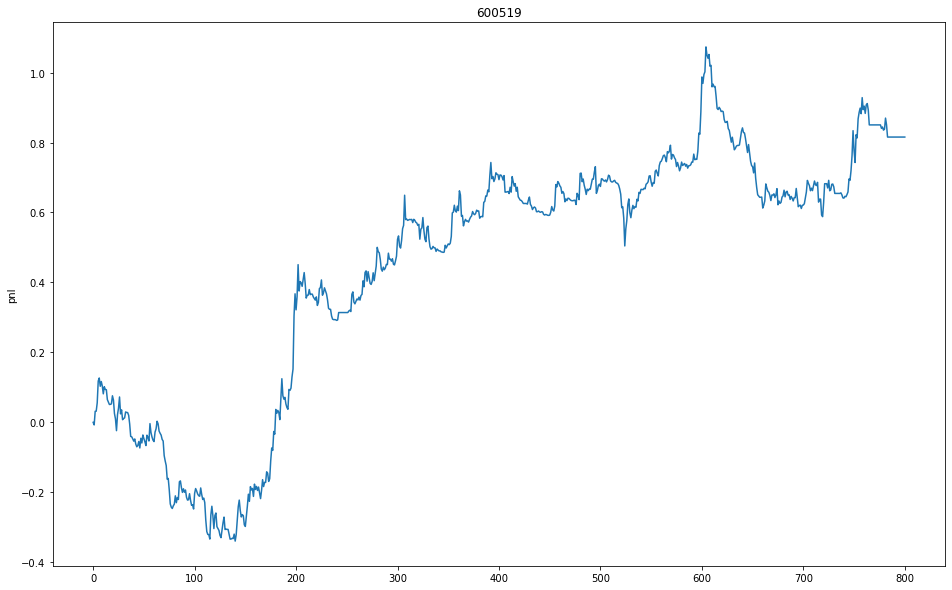

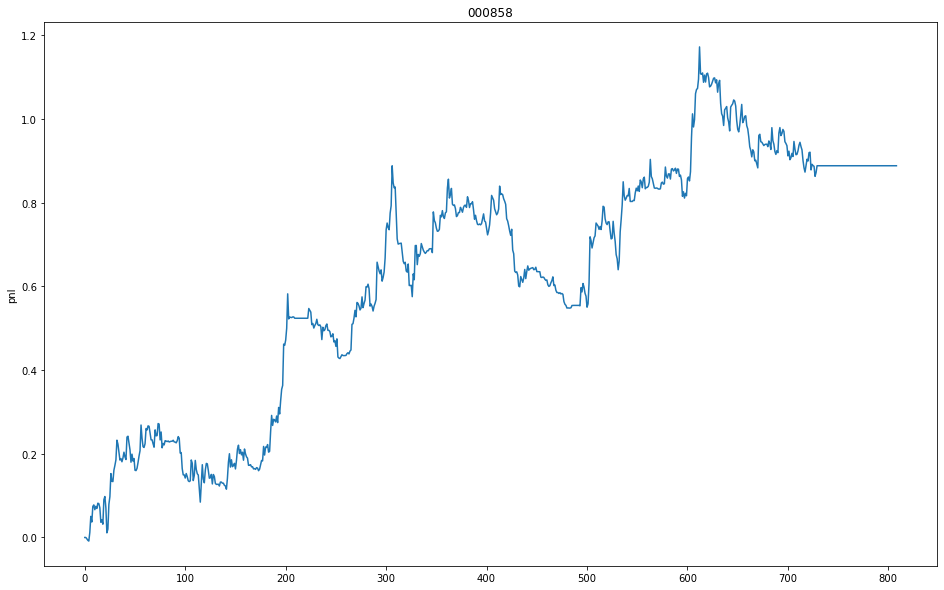

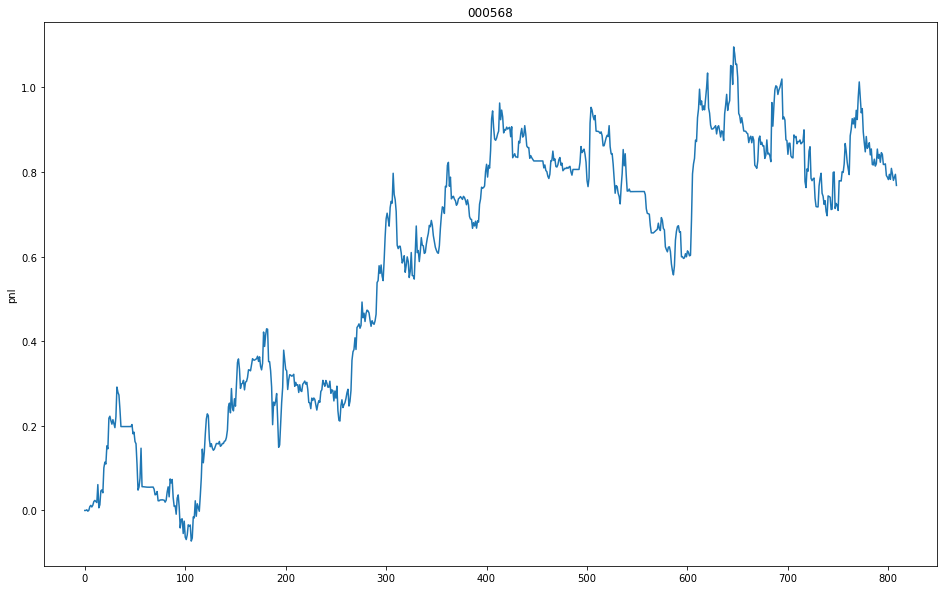

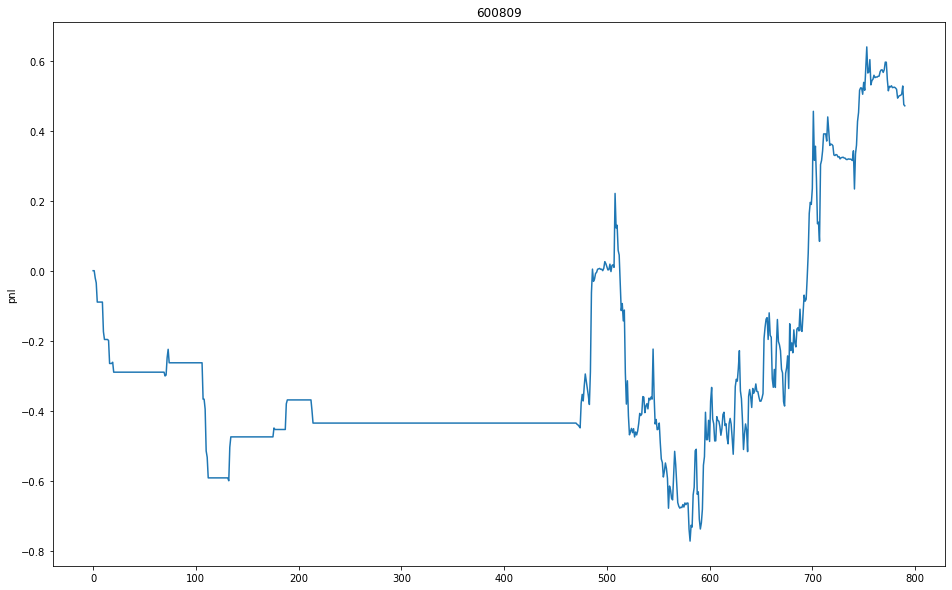

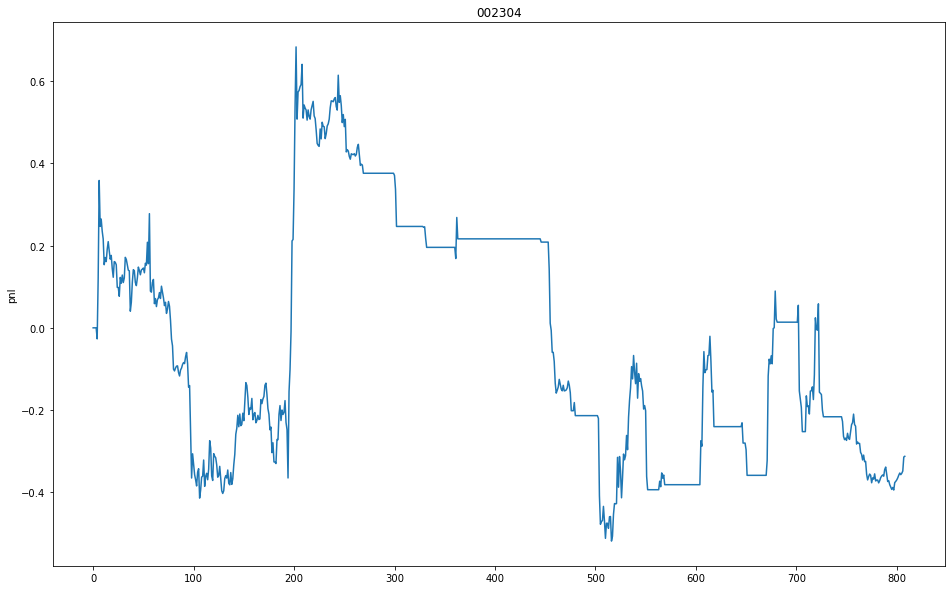

In [92]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "roll.wine.lasso.4096"
start_month = 0
min_pnl = 0.001
min_num = 10

train_end = 6
for i_product in range(n_product):
    all_pnl = np.array([])    
    for train_start in range(4):
        strat_name = strat+"."+all_dates[train_start]
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        good_strat = (train_stat["final.result"]["avg.ret"]>min_pnl) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        all_pnl = np.append(all_pnl, test_pnl)
    plt.figure(i_product, figsize=(16, 10))
    plt.title(product_list[i_product])
    plt.ylabel("pnl")
    plt.plot(all_pnl.cumsum());
    print("sharpe ", sharpe(all_pnl))

# sharpe  0.7261301778148582
# sharpe  0.8378991943684492
# sharpe  0.5483071103130536
# sharpe  0.26110314383403277
# sharpe  -0.16506403172634387


- we can see that the result is not so good but acceptable

- Congratulations! You have finished this course!
- Thank you very much for your participation! I wish you would enjoy taking this course!
- Happy trading in the future!